<a href="https://colab.research.google.com/github/X-ksana/GeneralScripts/blob/main/Nifti_ImageExtract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

- To generate dataset for subsequent task in the training pipeline
- The desired outcome will be transforming the 3D Cardiac MR data into 2D midsliced (middle layer based on z-axis) Cardiac MR with the same mask sliced at the same axis
- To store at either nifti or jpg

*NIfTI (Neuroimaging Informatics Technology Initiative) is a type of file format commonly used for neuroimaging.*



> An alternative approach would be to utilize the [2D Model Inference on a 3D Volume](https://github.com/Project-MONAI/tutorials/blob/main/modules/2d_inference_3d_volume.ipynb) project from MONAI. However, it's important to note that the dimensions H and W in this case should be adaptable to our current dataset, which may exhibit varying H and W dimensions



In [1]:
# Installing monai
# To change this line if using on HPC
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00


In [5]:
# Import dependencies
import os
import numpy as np
import torch
import nibabel as nib

from monai.transforms import Compose

from monai.transforms import (
    LoadImaged,
    Spacingd,
    Orientationd,
    CropForegroundd,
    ToTensord,
)

from monai.data import ImageDataset
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [6]:
# Mount google colab drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%pwd

'/content'

In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/PhD related/MONAI

/content/drive/MyDrive/Colab Notebooks/PhD related/MONAI


# Info: dataset

- The dataset we are using isAutomated Cardiac Diagnosis Challenge ([ACDC](https://www.creatis.insa-lyon.fr/Challenge/acdc/databases.html)) dataset.
- The testing folder named as `training` only consists of 5 patients for demonstration purposes.[download here](https://drive.google.com/drive/folders/1dGs6bXpXifm6C0L1EJ2Zx4A7b__Cp-6V?usp=sharing).


In [ ]:
# Define paths
data_dir = "training"  # Assuming "training" is the folder containing patient subfolders
output_dir = "extracted_images"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Now you can use `output_dir` for further operations
print(f"Directory '{output_dir}' is ready!")
output_dir = "extracted_images"


Directory 'extracted_images' is ready!


## Transformation of dataset

- Only minimal transformation required here
- We did not use `EnsureChannelFirstd`, which is oftenly used in `monai.transforms`to **ensure** that the channel dimension (if present) is the first dimension of the image data. It reorders the dimensions to follow the order `(C, H, W, D)` (channel, height, width, depth). If this is added our data shape will become `(1, H, W, D)`.
- `LoadImaged`
  - This transform loads an image from a file path.
  - The keys=["image","label"] argument specifies that the loaded image will be stored in a dictionary with the key "image" and "label".
- `Spacingd`
  - This transform resamples the image to a specified voxel spacing (pixel dimensions).
  - The `pixdim=(1.5, 1.5, 3.0)` argument sets the desired voxel spacing along the X, Y, and Z axes, respectively.
  - The `mode=("bilinear","nearest)` argument specifies the interpolation method for resampling (bilinear and nearest interpolation).
- `Orientationd`
  - This transform adjusts the image orientation based on the provided `axcodes`.
  - The `axcodes="RAI"` argument specifies the desired orientation using the Radiological convention (Right, Anterior, Inferior).
- `CropForegroundd`
  - This transform crops the image to include only the foreground (non-zero) region.
  - The source_key="image" argument indicates that the input image is used as the source for cropping.
- `ToTensord`
  - This transform converts the image data to a PyTorch tensor.



In [8]:
# Define MONAI transforms to load both image and label
transforms = Compose([
    LoadImaged(keys=["image", "label"]),  # Load both image and label
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear","nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAI"),
    CropForegroundd(keys=["image", "label"], source_key="image"),
    ToTensord(keys=["image", "label"])
])

/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (233, 9), channels = 232,please make sure the input is in the channel-first format.
  warnings.warn(


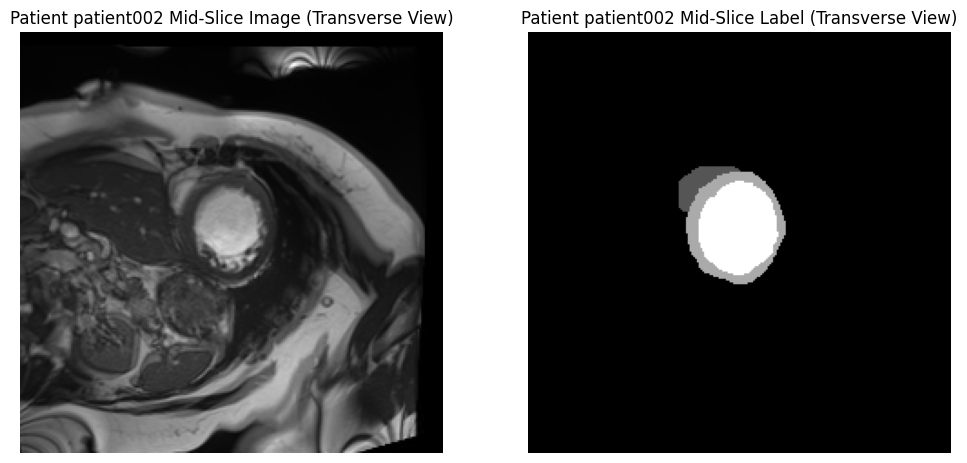

/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (267, 10), channels = 216,please make sure the input is in the channel-first format.
  warnings.warn(


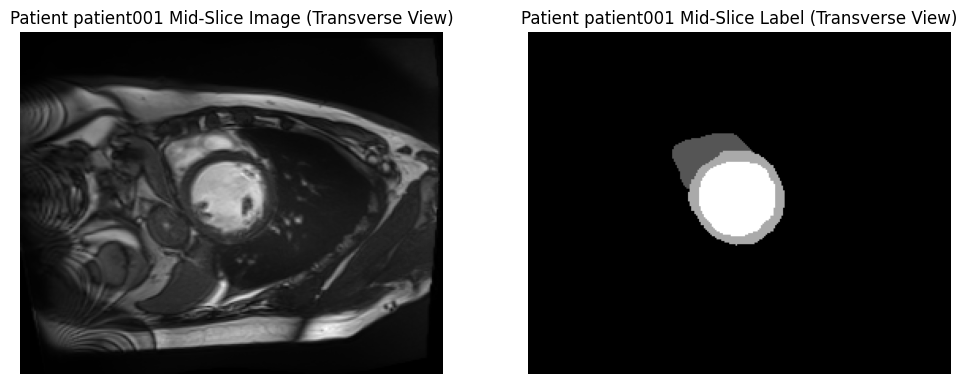

/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (267, 10), channels = 256,please make sure the input is in the channel-first format.
  warnings.warn(


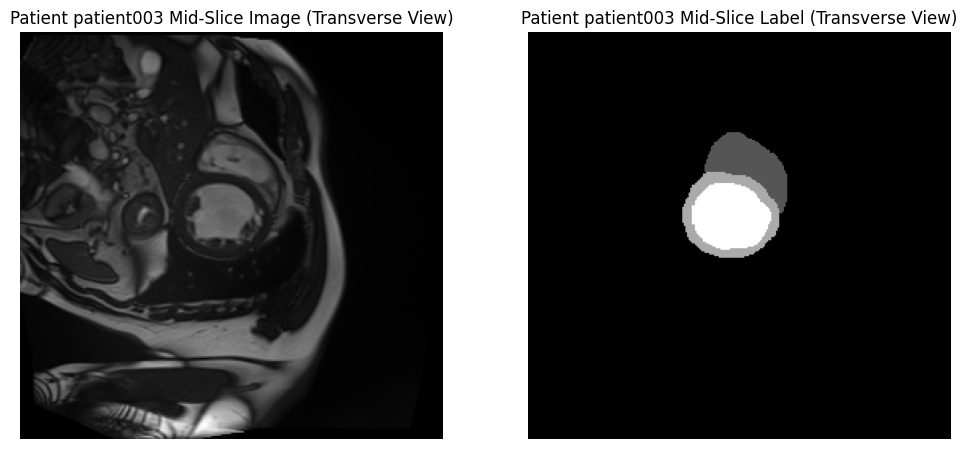

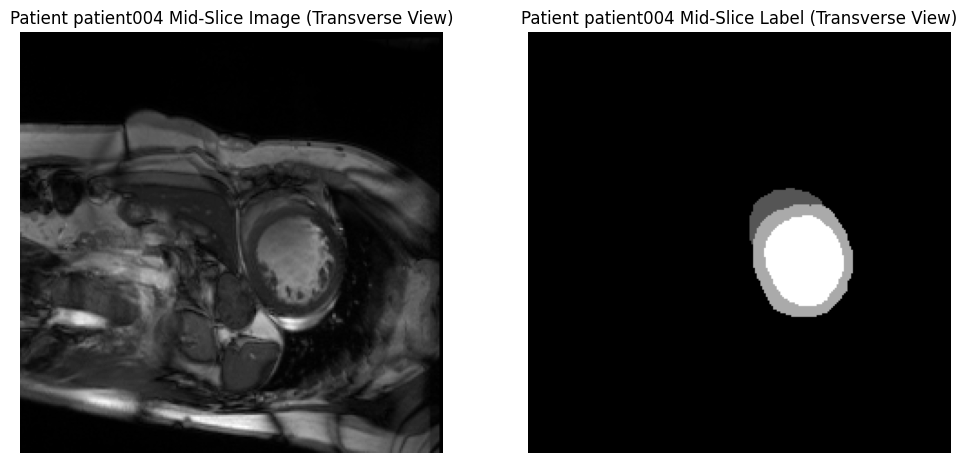

/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (203, 9), channels = 256,please make sure the input is in the channel-first format.
  warnings.warn(


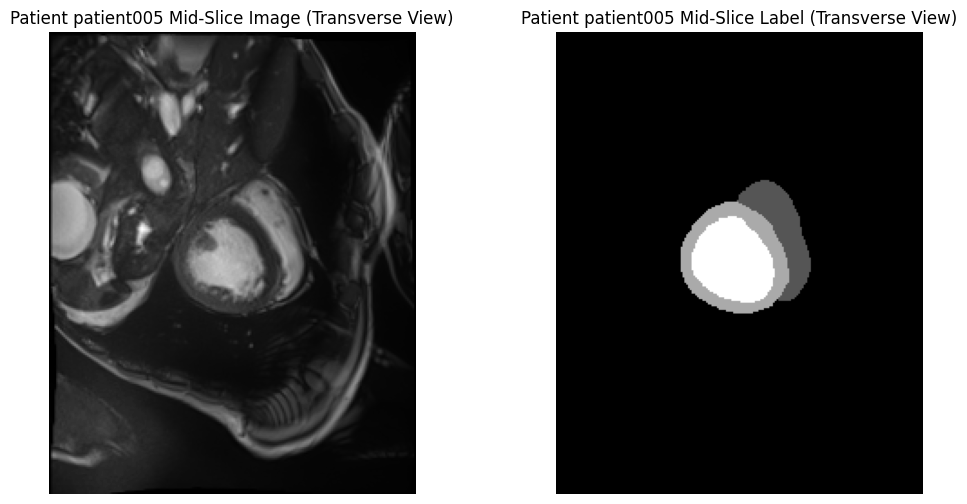

'\n    # This section for nifti file, alternative method will be to save the image straight without nifti being generated\n    # Save extracted images\n    os.makedirs(output_dir, exist_ok=True)\n    nib.save(nib.Nifti1Image(mid_slice_image_transverse_np, affine=np.eye(4)),\n             os.path.join(output_dir, f"patient_{patient_id}_mid_slice_image_transverse.nii.gz"))\n    nib.save(nib.Nifti1Image(mid_slice_label_transverse_np, affine=np.eye(4)),\n             os.path.join(output_dir, f"patient_{patient_id}_mid_slice_label_transverse.nii.gz"))\n  \n    print(f"Processed and saved data for patient {patient_id}")\n'

In [ ]:
# Read and process each patient's data
for patient_folder in os.listdir(data_dir):
    patient_id = patient_folder.split("_")[-1]  # Extract patient ID from folder name
    patient_data_dir = os.path.join(data_dir, patient_folder)
    image_file = os.path.join(patient_data_dir, f"{patient_folder}_frame01.nii.gz")
    label_file = os.path.join(patient_data_dir, f"{patient_folder}_frame01_gt.nii.gz")

    # Load image and label using MONAI transforms
    data = transforms({"image": image_file, "label": label_file})

    # Get the mid slice of Z-axis for image
    z_mid = data["image"].shape[2] // 2
    mid_slice_image_transverse_np = data["image"][:,:,z_mid]

    # Get the mid slice of Z-axis for label
    mid_slice_label_transverse_np = data["label"][:,:,z_mid]

    # Visualize the mid slice image and label
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(mid_slice_image_transverse_np, cmap="gray")
    plt.title(f"Patient {patient_id} Mid-Slice Image (Transverse View)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mid_slice_label_transverse_np, cmap="gray")
    plt.title(f"Patient {patient_id} Mid-Slice Label (Transverse View)")
    plt.axis("off")

    plt.show()


    # This section for nifti file, alternative method will be to save the image straight without nifti being generated
    # Save extracted images
    os.makedirs(output_dir, exist_ok=True)
    nib.save(nib.Nifti1Image(mid_slice_image_transverse_np, affine=np.eye(4)),
             os.path.join(output_dir, f"patient_{patient_id}_mid_slice_image_transverse.nii.gz"))
    nib.save(nib.Nifti1Image(mid_slice_label_transverse_np, affine=np.eye(4)),
             os.path.join(output_dir, f"patient_{patient_id}_mid_slice_label_transverse.nii.gz"))

    print(f"Processed and saved data for patient {patient_id}")


In [ ]:
# Converting nifti to jpg
# Define output directories for image and label JPEG files
output_dir_image = "output_image"
output_dir_label = "output_label"

# Create output directories if they don't exist
os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

# Read and process each patient's data
for patient_folder in os.listdir(data_dir):
    patient_id = patient_folder.split("_")[-1]  # Extract patient ID from folder name
    patient_data_dir = os.path.join(data_dir, patient_folder)
    image_file = os.path.join(patient_data_dir, f"{patient_folder}_frame01.nii.gz")
    label_file = os.path.join(patient_data_dir, f"{patient_folder}_frame01_gt.nii.gz")

    # Load image and label using MONAI transforms
    data = transforms({"image": image_file, "label": label_file})

    # Get the mid slice of Z-axis for image
    z_mid = data["image"].shape[2] // 2
    mid_slice_image_transverse_np = data["image"][:,:,z_mid]

    # Get the mid slice of Z-axis for label
    mid_slice_label_transverse_np = data["label"][:,:,z_mid]

    # Save mid-slice image as JPEG
    plt.imsave(os.path.join(output_dir_image, f"patient_{patient_id}_mid_slice_image.jpg"), mid_slice_image_transverse_np, cmap="gray")

    # Save mid-slice label as JPEG
    plt.imsave(os.path.join(output_dir_label, f"patient_{patient_id}_mid_slice_label.jpg"), mid_slice_label_transverse_np, cmap="gray")

    print(f"Processed and saved data for patient {patient_id}")


Processed and saved data for patient patient002
Processed and saved data for patient patient001
Processed and saved data for patient patient003
Processed and saved data for patient patient004
Processed and saved data for patient patient005


In [ ]:
# Alternative: Save as jpg without nifti

# Define output directories for image and label JPEG files
output_dir_image = "output_image"
output_dir_label = "output_label"

# Create output directories if they don't exist
os.makedirs(output_dir_image, exist_ok=True)
os.makedirs(output_dir_label, exist_ok=True)

# Read and process each patient's data
for patient_folder in os.listdir(data_dir):
    patient_id = patient_folder.split("_")[-1]  # Extract patient ID from folder name
    patient_data_dir = os.path.join(data_dir, patient_folder)
    image_file = os.path.join(patient_data_dir, f"{patient_folder}_frame01.nii.gz")
    label_file = os.path.join(patient_data_dir, f"{patient_folder}_frame01_gt.nii.gz")

    # Load image and label using MONAI transforms
    data = transforms({"image": image_file, "label": label_file})

    # Get the mid slice of Z-axis for image
    z_mid = data["image"].shape[2] // 2
    mid_slice_image_transverse_np = data["image"][:,:,z_mid]

    # Get the mid slice of Z-axis for label
    mid_slice_label_transverse_np = data["label"][:,:,z_mid]

    # Save mid-slice image as JPEG
    plt.imshow(mid_slice_image_transverse_np, cmap="gray")
    plt.title(f"Patient {patient_id} Mid-Slice Image (Transverse View)")
    plt.axis("off")
    plt.savefig(os.path.join(output_dir_image, f"patient_{patient_id}_mid_slice_image.jpg"), bbox_inches="tight")
    plt.close()  # Close the current figure to free memory

    # Save mid-slice label as JPEG
    plt.imshow(mid_slice_label_transverse_np, cmap="gray")
    plt.title(f"Patient {patient_id} Mid-Slice Label (Transverse View)")
    plt.axis("off")
    plt.savefig(os.path.join(output_dir_label, f"patient_{patient_id}_mid_slice_label.jpg"), bbox_inches="tight")
    plt.close()  # Close the current figure to free memory

    print(f"Processed and saved data for patient {patient_id}")


Processed and saved data for patient patient002


/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (267, 10), channels = 216,please make sure the input is in the channel-first format.
  warnings.warn(


Processed and saved data for patient patient001


/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (267, 10), channels = 256,please make sure the input is in the channel-first format.
  warnings.warn(


Processed and saved data for patient patient003


/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (233, 9), channels = 232,please make sure the input is in the channel-first format.
  warnings.warn(


Processed and saved data for patient patient004


/usr/local/lib/python3.10/dist-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAI') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (203, 9), channels = 256,please make sure the input is in the channel-first format.
  warnings.warn(


Processed and saved data for patient patient005


## Choosing `pixdim`

### What should be considered?
1. Physical Voxel Size
- `pixdim` is the physical step size between pixel or voxel center points along each axis (X, Y, Z).
- It defines the spacing between adjacent pixels or voxels in the image.
- Choose values that reflect the actual physical dimensions of the imaging modality (e.g., MRI, CT, PET).
- Common units include millimeters (mm) for spatial dimensions and seconds (s) for temporal dimensions.

2. Modality-specific considerations
- Different imaging modalities have varying inherent resolutions and voxel sizes.
- For example:
  - MRI: Typical voxel sizes range from 1 mm to 3 mm in each dimension.
  - CT: Voxel sizes can be smaller (sub-millimeter) due to higher spatial resolution.
  - PET: Voxel sizes depend on the scanner and reconstruction parameters.

3. Trade-Offs
- Smaller voxel sizes provide higher spatial resolution but may increase memory and computation requirements.
- Larger voxel sizes reduce memory demands but may sacrifice fine details (an increased signal-to-noise ratio).


4. Clinical context
- Consider the clinical context and the specific anatomical structures you are studying.
- For cardiac imaging, smaller voxel sizes may be necessary to capture fine structures.
- For whole-brain studies, larger voxel sizes may suffice.

5. Standard practices
- Some studies follow established standards for voxel sizes.
- For example:
  - FMRI: Voxel sizes around 3 mm isotropic (equal in all dimensions) are common.
  - T1-weighted anatomical MRI: Voxel sizes around 1 mm isotropic are often used.

6. Literature and Experts:
- Refer to relevant literature, guidelines, or consult domain experts.
Understand the impact of voxel size on your specific analysis (e.g., segmentation, registration, feature extraction).

## Interpolation

### Differences between bilinear and nearest(-neighbor) interpolation

1. Nearest-neighbor:
- Simplest way to increase size of an image
- Replacing every pixel with the value of the nearest pixel in the original image
- Result in larger image, but may have jaggedness due to abrupt transition between neighboring pixels
- Preserves all original detail but lacks smoothness

2. Bilinear:
- More sophisticated method for changing size of an image
- Use weighted average of the 4 nearest cell centers (pixels) to calculate the value of each pixel.
- It considered the contributions of the 4 nearest pixels (forming a square) and interpolates linearly between them.
- Results in smoother image

Trade-off:
Nearest - preserves shape edges but lacks smoothness; Bilinear - smoother results but may slightly blur fine details.

# References

- O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al.
"Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and
Diagnosis: Is the Problem Solved ?" in *IEEE Transactions on Medical Imaging*,
vol. 37, no. 11, pp. 2514-2525, Nov. 2018.doi: 10.1109/TMI.2018.2837502
- (nifti [link to doc](https://nifti.nimh.nih.gov/nifti-1/documentation/nifti1fields/nifti1fields_pages/dim.html/document_view))
- [Introduction to medical image processing with Python: CT lung and vessel segmentation without labels](https://theaisummer.com/medical-image-python/) - find_pix_dim code available
